In [1]:
# import os
# import warnings
# import mne
# import numpy as np
# from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import multiprocessing
# from multiprocessing import Pool
# import plotly.graph_objects as go
# import pandas as pd
# import umap.umap_ as umap
# from tqdm import tqdm

# # Suppress warnings
# warnings.filterwarnings('ignore')

# # Import the class of dataset
# os.chdir('../..')
# from Scripts.Data_Loader import EIRDataset

In [2]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import DBSCAN


os.chdir('../..')

In [3]:
def collect_valid_paths():
    root_dir = "Generated/Data"
    s_dir_pattern = re.compile(r"^S_\d+$")
    trial_dir_pattern = re.compile(r"^Trial_\d+$")
    valid_dirs = []
    for s_dir in os.listdir(root_dir):
        s_path = os.path.join(root_dir, s_dir)
        if os.path.isdir(s_path) and s_dir_pattern.match(s_dir):
            for trial_dir in os.listdir(s_path):
                trial_path = os.path.join(s_path, trial_dir)
                if os.path.isdir(trial_path) and trial_dir_pattern.match(trial_dir):
                    if any(os.path.isfile(os.path.join(trial_path, f)) for f in os.listdir(trial_path)):
                        valid_dirs.append(trial_path)
    return valid_dirs

all_paths = collect_valid_paths()

print(f"–ù–∞–π–¥–µ–Ω–æ {len(all_paths)} –ø–æ–¥—Ö–æ–¥—è—â–∏—Ö –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–π")

–ù–∞–π–¥–µ–Ω–æ 27 –ø–æ–¥—Ö–æ–¥—è—â–∏—Ö –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–π


In [4]:
import mne
import os
import warnings
from multiprocessing import Pool

def load_eeg(path):
    eeg_clean_path = os.path.join(path, "EEG_clean.fif")
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
        clean_eeg = mne.io.read_raw_fif(eeg_clean_path, preload=True, verbose=False)
    
    clean_eeg.pick_types(eeg=True, verbose=False)

    # –ò–∑–≤–ª–µ—á–µ–º S_13 –∏ Trial_2 –∏–∑ –ø—É—Ç–∏
    parts = path.strip(os.sep).split(os.sep)
    subj = parts[-2]
    trial = parts[-1]

    subj_id = int(subj.split('_')[-1])
    trial_id = int(trial.split('_')[-1])

    
    key = f"S{subj_id}_T{trial_id}"

    # !!!TODO!!! —Å—é–¥–∞ –¥–æ–±–∞–≤–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –∏—Å–ø—ã—Ç—É–µ–º—ã—Ö —Å —Ç–∞–±–ª–∏—Ü—ã.
    return key, [clean_eeg, subj_id, trial_id]
        

# –ü–∞—Ä–∞–ª–ª–µ–ª—å–Ω–∞—è –∑–∞–≥—Ä—É–∑–∫–∞
with Pool(processes=72)  as pool:
    results = list(tqdm(pool.imap(load_eeg, all_paths), total=len(all_paths)))

# –°–æ–±—Ä–∞—Ç—å —Å–ª–æ–≤–∞—Ä—å, –∏—Å–∫–ª—é—á–∏–≤ –æ—à–∏–±–∫–∏
data_tuple = {k: v for k, v in results if k is not None}

eeg, subj, trial = data_tuple['S6_T1']

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27/27 [01:46<00:00,  3.96s/it]


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


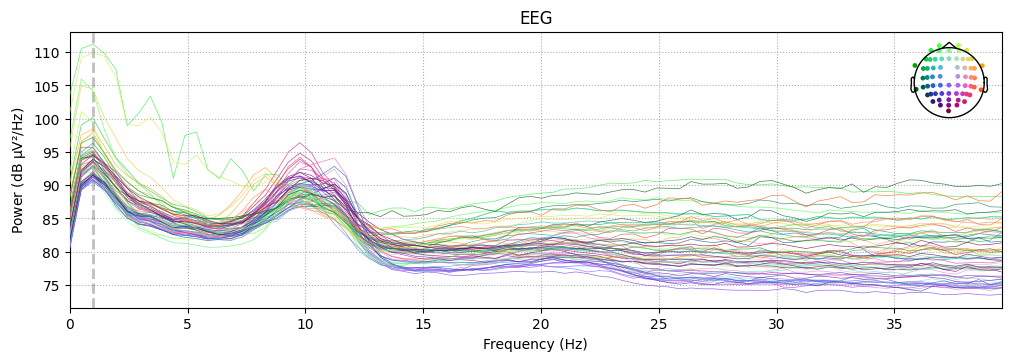

In [7]:
eeg.plot_psd(fmax=40, show=True)

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_array_morlet

n_jobs = 16

psds_array = []
for key, (eeg, subj, trial) in data_tuple.items():
    # –ü–æ–ª—É—á–∞–µ–º –¥–∞–Ω–Ω—ã–µ (n_channels, n_times)
    data = eeg.get_data()
    
    # –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –ú–æ—Ä–ª–µ
    freqs = np.linspace(2, 40, 40*2)  # –ß–∞—Å—Ç–æ—Ç—ã –æ—Ç 2 –¥–æ 40 –ì—Ü
    n_cycles = freqs / 2.0          # –ë–æ–ª—å—à–µ —Ü–∏–∫–ª–æ–≤ ‚Äî –≤—ã—à–µ —á–∞—Å—Ç–æ—Ç–Ω–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å
    
    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ (n_epochs=1, n_channels, n_times)
    data_reshaped = data[np.newaxis, :, :]
    
    # –ú–æ—Ä–ª–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ (–ø–æ–ª—É—á–∏–º –º–æ—â–Ω–æ—Å—Ç—å)
    power = tfr_array_morlet(
        data_reshaped,
        sfreq=eeg.info['sfreq'],
        freqs=freqs,
        n_cycles=n_cycles,
        output='power',
        decim=10,          # —É—Å–∫–æ—Ä–∏–º –≤—ã—á–∏—Å–ª–µ–Ω–∏—è (10x —É–º–µ–Ω—å—à–µ–Ω–∏–µ)
        n_jobs=n_jobs
    )  # –†–µ–∑—É–ª—å—Ç–∞—Ç: (1, n_channels, n_freqs, n_times)
    
    # –£—Å—Ä–µ–¥–Ω—è–µ–º –ø–æ –≤—Ä–µ–º–µ–Ω–∏
    power_mean = power.mean(axis=-1)[0]  # (n_channels, n_freqs)

    psds_array.append([power_mean, subj, trial])

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ –º–∞—Å—Å–∏–≤ (—Ö–æ—Ç—è —ç—Ç–æ —Å–ø–∏—Å–æ–∫ —Å –º–∞—Å—Å–∏–≤–∞–º–∏ ‚Äî –Ω–æ—Ä–º –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è)
np.savez("morlet_psds_array.npz", psds_array=psds_array)

psd_array[0][0].shape

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


In [ ]:
import numpy as np

# –ó–∞–≥—Ä—É–∂–∞–µ–º
loaded = np.load("morlet_psds_array.npz", allow_pickle=True)

# –ò–∑–≤–ª–µ–∫–∞–µ–º —Å–ø–∏—Å–æ–∫
psds_array_loaded = loaded["psds_array"]

# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è:
power_mean, subj, trial = psds_array_loaded[0]
print(power_mean.shape)  # (n_channels, n_freqs)
print(subj, trial)

In [ ]:
psds_array = np.array(psds_list)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done  61 out of  63 | elapsed:  5.6min remaining:   11.1s
[Parallel(n_jobs=16)]: Done  63 out of  63 | elapsed:  5.6min finished


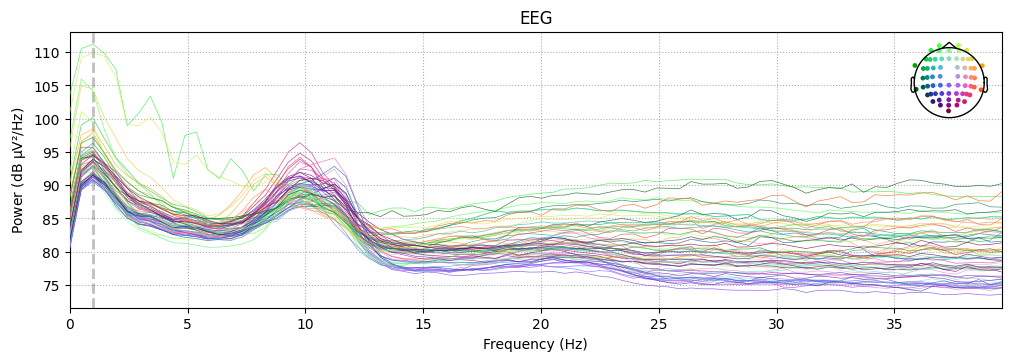

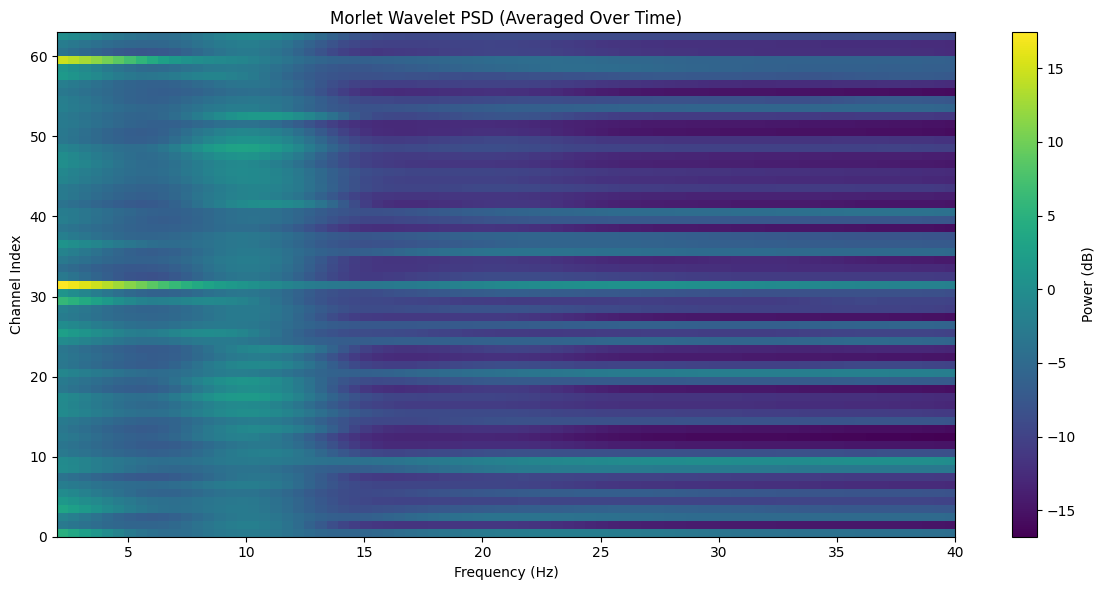

In [10]:
# # –ü–æ—Å—Ç—Ä–æ–∏–º –∞–Ω–∞–ª–æ–≥ PSD-–≥—Ä–∞—Ñ–∏–∫–∞
# plt.figure(figsize=(12, 6))
# plt.imshow(
#     10 * np.log10(power_mean),  # –ø–µ—Ä–µ–≤–æ–¥–∏–º –≤ dB
#     aspect='auto',
#     origin='lower',
#     extent=[freqs[0], freqs[-1], 0, eeg.info['nchan']],
#     cmap='viridis'
# )
# plt.colorbar(label='Power (dB)')
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Channel Index")
# plt.title("Morlet Wavelet PSD (Averaged Over Time)")
# plt.tight_layout()
# plt.show()

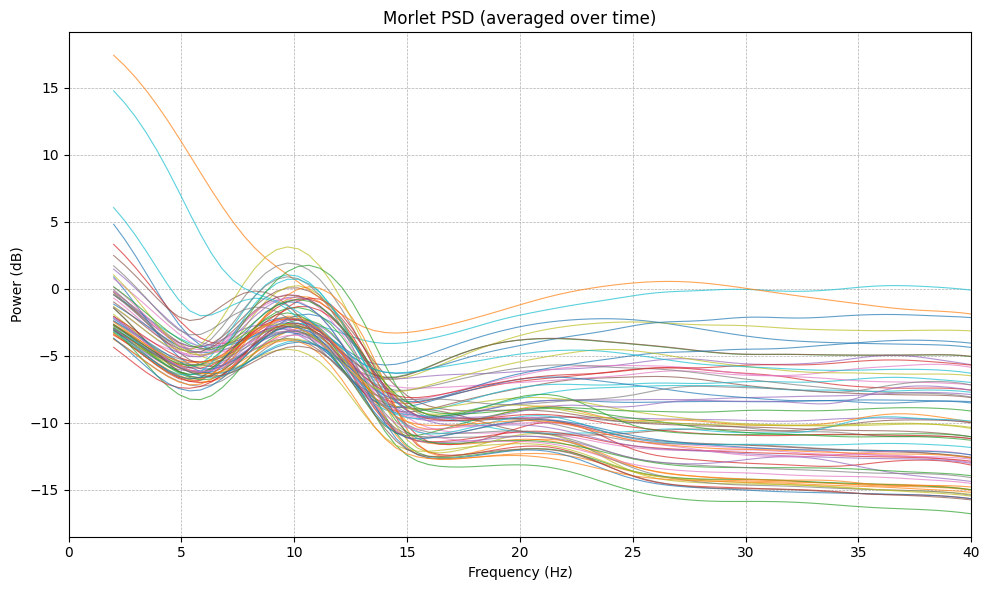

In [17]:
# # –ü–µ—Ä–µ–≤–æ–¥ –≤ dB
# power_db = 10 * np.log10(power_mean + 1e-20)  # –¥–æ–±–∞–≤–∏–º eps, —á—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å log(0)

# # ===== üé® –†–∏—Å—É–µ–º –∫–∞–∫ raw.plot_psd() =====
# plt.figure(figsize=(10, 6))

# for i, ch_name in enumerate(eeg.ch_names):
#     plt.plot(freqs, power_db[i], label=ch_name, linewidth=0.8, alpha=0.7)

# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power (dB)')
# plt.title('Morlet PSD (averaged over time)')
# plt.xlim(0, 40)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.tight_layout()

# # –ï—Å–ª–∏ –∫–∞–Ω–∞–ª–æ–≤ –Ω–µ–º–Ω–æ–≥–æ ‚Äî –ø–æ–∫–∞–∂–µ–º –ª–µ–≥–µ–Ω–¥—É
# if len(eeg.ch_names) <= 20:
#     plt.legend(fontsize=7, loc='upper right')

# plt.show()


In [ ]:
from mne.time_frequency import tfr_array_morlet

# Pick only EEG channels
eeg.pick_types(eeg=True)

# Get the data (n_channels, n_times)
data = eeg.get_data()

# Define frequencies of interest (e.g., 2‚Äì40 Hz)
freqs = np.linspace(1, 40, 40)  # 39 frequencies: 2, 3, ..., 40

# Define number of cycles for each frequency (can be fixed or proportional)
n_cycles = freqs / 2.  # More cycles = better frequency resolution

# Compute Morlet power (TFR)
# tfr_array_morlet expects shape (n_epochs, n_channels, n_times), so reshape
data_reshaped = data[np.newaxis, :, :]  # Shape: (1, n_channels, n_times)

power = tfr_array_morlet(
    data_reshaped,
    sfreq=eeg.info['sfreq'],
    freqs=freqs,
    n_cycles=n_cycles,
    output='power',
    decim=1,
    n_jobs=72
)  # Output shape: (1, n_channels, n_freqs, n_times)

# Average over time
power_mean = power.mean(axis=-1)[0]  # Shape: (n_channels, n_freqs)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=72)]: Using backend LokyBackend with 72 concurrent workers.


In [13]:
n_jobs = 1  # –∫–∞–∂–¥—ã–π –ø—Ä–æ—Ü–µ—Å—Å –∏—Å–ø–æ–ª—å–∑—É–µ—Ç 1 –ø–æ—Ç–æ–∫ –≤–Ω—É—Ç—Ä–∏

def compute_psd(args):
    freqs = np.linspace(1, 40, 40*10)  # –æ—Ç 1 –¥–æ 40 –ì—Ü (—à–∞–≥ 1/40)
    n_cycles = freqs / 2.  # —Ü–∏–∫–ª/—á–∞—Å—Ç–æ—Ç–∞
    
    key, (raw, *metadata) = args
    power = mne.time_frequency.tfr_array_morlet(
        raw.get_data()[np.newaxis], sfreq=raw.info['sfreq'],
        freqs=freqs, n_cycles=n_cycles, output='power', n_jobs=1, verbose="error"
    )[0]  # shape: (n_channels, n_freqs, n_times)
    
    # –£—Å—Ä–µ–¥–Ω–µ–Ω–∏–µ –ø–æ –≤—Ä–µ–º–µ–Ω–∏: –∏—Ç–æ–≥–æ–≤—ã–π –≤–µ–∫—Ç–æ—Ä –Ω–∞ –∫–∞–Ω–∞–ª: 40 —á–∞—Å—Ç–æ—Ç
    power_mean = power.mean(axis=-1)  # shape: (n_channels, n_freqs)
    
    # –°–æ—Ö—Ä–∞–Ω–∏–º –∫–∞–∂–¥—ã–π –∫–∞–Ω–∞–ª –æ—Ç–¥–µ–ª—å–Ω–æ
    return power_mean

# Prepare data for parallel processing
data_list = list(data_tuple.items())

# Use multiprocessing to compute PSDs in parallel
with Pool(processes=n_jobs) as pool:
    psds_list = list(tqdm(pool.imap(compute_psd, data_list), total=len(data_list)))

  0%|          | 0/27 [00:02<?, ?it/s]


MemoryError: Unable to allocate 291. GiB for an array with shape (63, 1, 400, 1548000) and data type float64

In [ ]:
psds_list[0].shape

In [ ]:
# Convert list of PSDs to a numpy array
psds_array = np.array(psds_list)

# Vectorize 
psds_array = psds_array.reshape((psds_array.shape[0], -1))

# DBSCAN clustering in high-dimensional space
clustering_high_dim = DBSCAN(eps=0.5, min_samples=5).fit(psds_array)
labels_high_dim = clustering_high_dim.labels_

# PCA 2D

In [ ]:
# Assuming 'psds_array' is your high-dimensional data
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(psds_array)

In [ ]:
metadata = [item[1][1:] for item in data_list]  
labels = [meta[0] for meta in metadata]  
subject_ids = [meta[1] for meta in metadata]
trial_ids = [meta[2] for meta in metadata]
indices = [meta[3] for meta in metadata]
task_types = [meta[4] for meta in metadata]

df = pd.DataFrame(reduced_data, columns=['PCA-1', 'PCA-2'])
df['Cluster'] = labels_high_dim
df['Label'] = labels
df['Subject_ID'] = subject_ids
df['Trial_ID'] = trial_ids
df['Index'] = indices
df['Task_Type'] = task_types
df['Metadata'] = [str(meta) for meta in metadata]

coloring_vars = ['Cluster', 'Label', 'Subject_ID', 'Trial_ID', 'Index', 'Task_Type']
fig = go.Figure()

for var in coloring_vars:
    if var in ['Label', 'Subject_ID', 'Trial_ID', 'Task_Type']:
        unique_values = df[var].unique()
        color_map = {val: i for i, val in enumerate(unique_values)}
        colors = [color_map[val] for val in df[var]]
    else:
        colors = df[var]

    fig.add_trace(go.Scatter(
        x=df['PCA-1'],
        y=df['PCA-2'],
        mode='markers',
        marker=dict(color=colors),
        hoverinfo='text',
        hovertext=df['Metadata'],
        visible=var == 'Cluster'  
    ))

buttons = []
for i, var in enumerate(coloring_vars):
    buttons.append(dict(
        label=var,
        method='update',
        args=[{'visible': [j == i for j in range(len(coloring_vars))]}]
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        pad={'r': 10, 't': 10},
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.15,
        yanchor='top'
    )],
    title='PCA Reduced Space',
)

fig.show()
fig.write_html('pca_2d.html', include_plotlyjs='cdn', full_html=True)

# PCA 3D

In [ ]:
# Assuming 'psds_array' is your high-dimensional data
pca = PCA(n_components=3, random_state=42)
reduced_data = pca.fit_transform(psds_array)

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

metadata = [item[1][1:] for item in data_list]  
labels = [meta[0] for meta in metadata]  
subject_ids = [meta[1] for meta in metadata]
trial_ids = [meta[2] for meta in metadata]
indices = [meta[3] for meta in metadata]
task_types = [meta[4] for meta in metadata]

df = pd.DataFrame(reduced_data, columns=['PCA-1', 'PCA-2', 'PCA-3'])
df['Cluster'] = labels_high_dim
df['Label'] = labels
df['Subject_ID'] = subject_ids
df['Trial_ID'] = trial_ids
df['Index'] = indices
df['Task_Type'] = task_types
df['Metadata'] = [str(meta) for meta in metadata]

coloring_vars = ['Cluster', 'Label', 'Subject_ID', 'Trial_ID', 'Index', 'Task_Type']

fig = go.Figure()

for var in coloring_vars:
    if var in ['Label', 'Subject_ID', 'Trial_ID', 'Task_Type']:
        unique_values = df[var].unique()
        color_map = {val: i for i, val in enumerate(unique_values)}
        colors = [color_map[val] for val in df[var]]
    else:
        colors = df[var]

    fig.add_trace(go.Scatter3d(
        x=df['PCA-1'],
        y=df['PCA-2'],
        z=df['PCA-3'],
        mode='markers',
        marker=dict(color=colors),
        hoverinfo='text',
        hovertext=df['Metadata'],
        visible=var == 'Cluster'  
    ))

buttons = []
for i, var in enumerate(coloring_vars):
    buttons.append(dict(
        label=var,
        method='update',
        args=[{'visible': [j == i for j in range(len(coloring_vars))]}]
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        pad={'r': 10, 't': 10},
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.15,
        yanchor='top'
    )],
    title='UMAP Reduced Space',
    scene = dict(
        xaxis_title='PCA-1',
        yaxis_title='PCA-2',
        zaxis_title='PCA-3'),
)

fig.show()
fig.write_html('pca_3d.html', include_plotlyjs='cdn', full_html=True)

# UMAP 3D

In [ ]:


# UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=3, random_state=42)
reduced_data = reducer.fit_transform(psds_array)

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

metadata = [item[1][1:] for item in data_list]  
labels = [meta[0] for meta in metadata]  
subject_ids = [meta[1] for meta in metadata]
trial_ids = [meta[2] for meta in metadata]
indices = [meta[3] for meta in metadata]
task_types = [meta[4] for meta in metadata]

df = pd.DataFrame(reduced_data, columns=['UMAP-1', 'UMAP-2', 'UMAP-3'])
df['Cluster'] = labels_high_dim
df['Label'] = labels
df['Subject_ID'] = subject_ids
df['Trial_ID'] = trial_ids
df['Index'] = indices
df['Task_Type'] = task_types
df['Metadata'] = [str(meta) for meta in metadata]

coloring_vars = ['Cluster', 'Label', 'Subject_ID', 'Trial_ID', 'Index', 'Task_Type']

fig = go.Figure()

for var in coloring_vars:
    if var in ['Label', 'Subject_ID', 'Trial_ID', 'Task_Type']:
        unique_values = df[var].unique()
        color_map = {val: i for i, val in enumerate(unique_values)}
        colors = [color_map[val] for val in df[var]]
    else:
        colors = df[var]

    fig.add_trace(go.Scatter3d(
        x=df['UMAP-1'],
        y=df['UMAP-2'],
        z=df['UMAP-3'],
        mode='markers',
        marker=dict(color=colors),
        hoverinfo='text',
        hovertext=df['Metadata'],
        visible=var == 'Cluster'  
    ))

buttons = []
for i, var in enumerate(coloring_vars):
    buttons.append(dict(
        label=var,
        method='update',
        args=[{'visible': [j == i for j in range(len(coloring_vars))]}]
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        pad={'r': 10, 't': 10},
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.15,
        yanchor='top'
    )],
    title='UMAP Reduced Space',
    scene = dict(
        xaxis_title='UMAP-1',
        yaxis_title='UMAP-2',
        zaxis_title='UMAP-3'),
)

fig.show()
fig.write_html('umap_3d.html', include_plotlyjs='cdn', full_html=True)

In [ ]:
# UMAP 2D

In [ ]:
import umap.umap_ as umap

# UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = reducer.fit_transform(psds_array)

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

metadata = [item[1][1:] for item in data_list]  
labels = [meta[0] for meta in metadata]  
subject_ids = [meta[1] for meta in metadata]
trial_ids = [meta[2] for meta in metadata]
indices = [meta[3] for meta in metadata]
task_types = [meta[4] for meta in metadata]

df = pd.DataFrame(reduced_data, columns=['UMAP-1', 'UMAP-2'])
df['Cluster'] = labels_high_dim
df['Label'] = labels
df['Subject_ID'] = subject_ids
df['Trial_ID'] = trial_ids
df['Index'] = indices
df['Task_Type'] = task_types
df['Metadata'] = [str(meta) for meta in metadata]

coloring_vars = ['Cluster', 'Label', 'Subject_ID', 'Trial_ID', 'Index', 'Task_Type']
fig = go.Figure()

for var in coloring_vars:
    if var in ['Label', 'Subject_ID', 'Trial_ID', 'Task_Type']:
        unique_values = df[var].unique()
        color_map = {val: i for i, val in enumerate(unique_values)}
        colors = [color_map[val] for val in df[var]]
    else:
        colors = df[var]

    fig.add_trace(go.Scatter(
        x=df['UMAP-1'],
        y=df['UMAP-2'],
        mode='markers',
        marker=dict(color=colors),
        hoverinfo='text',
        hovertext=df['Metadata'],
        visible=var == 'Cluster'  
    ))

buttons = []
for i, var in enumerate(coloring_vars):
    buttons.append(dict(
        label=var,
        method='update',
        args=[{'visible': [j == i for j in range(len(coloring_vars))]}]
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        pad={'r': 10, 't': 10},
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.15,
        yanchor='top'
    )],
    title='UMAP Reduced Space',
)

fig.show()
fig.write_html('umap_2d.html', include_plotlyjs='cdn', full_html=True)